<h1>Object Detection using Power AI Vision API calls</h1>

This notebook allows you to make API calls to a server running Power AI Vision to perform object detection on videos.  

Special thanks to Mark Sturdevant from IBM for code.  Check out his GitHub with the code at https://github.com/IBM/powerai-counting-cars/blob/master/README.md.

In [1]:
# Set this URL to the API endpoint of your deployed model.
POWER_AI_VISION_API_URL = Insert_API_Key_Here


In [2]:
# Output dir to hold/cache the original frames
FRAMES_DIR = "frames"  
# Output dir to hold the annotated frames
OUTPUT_DIR = "output"  
# Classify every n frames
# TODO:  Possibly add tracking
SAMPLING = 1  
# Confidence threshold to filter iffy objects
CONFIDENCE = 0.90  
# If running the notebook on Windows, the \ has to be replaced with / in file names and paths.
# Use Y if running on Windows or N if running on a flavor of Linux
WINDOWS = "Y" 

# OpenCV colors are (B, G, R) tuples -- RGB in reverse
WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)
BLACK = (0, 0, 0)

In [3]:
import json
import glob
import math
import os
import shutil

import cv2
from IPython.display import clear_output, Image, display
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

%matplotlib notebook

In [4]:
# Name of input video
input_video = "Input_Video_Name.mp4"

<h1>Create the directories</h1>

In [5]:
if not os.path.isdir(FRAMES_DIR):
    os.mkdir(FRAMES_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


<h1>Parse and explode the video file into JPGs</h1>

Each frame is saved as an individual JPG file for later use.

In [6]:
# Load the input video
if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

# Get the total number of frames in the video
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count estimate is %d" % total_frames)

FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Frame Rate: %s fps" % (FRAME_FPS))
print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))

# Read each frame and write it to a jpg file
num = 0
while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
        print("Writing frame {num} of {total_frames}".format(
            num=num, total_frames=total_frames), end="\r")
        cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
            num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num))



Frame count estimate is 1004
Frame Rate: 30 fps
Frame Dimensions: 1072x1920
Writing frame 1004 of 1004
Wrote 1004 frames


<h1>PowerAI Vision inference wrapper</h1>

Define a helper/wrapper to call PowerAI Vision and return the inference result.

In [7]:
# Read the file and make the API call back to the PAIV server
# This works well if the network is fast, but can have problems over a slow connection
s = requests.Session()

def detect_objects(filename):

    with open(filename, 'rb') as f:
        # WARNING! verify=False is here to allow an untrusted cert!
        r = s.post(POWER_AI_VISION_API_URL,
                   files={'files': (filename, f)},
                   verify=False)

    return r.status_code, json.loads(r.text)

<h1>Test the API on a single frame</h1>

Look at the result of a single inference operation from the PowerAI Vision Object Detection API. We see a standard HTTP return code, and a JSON response which includes the image URL, and tuples that indicate the confidence and bounding-box coordinates of the objects that we classified.

In [8]:
# This is a sanity check to make sure everything is working fine
# rc is the response code from the API call
rc, jsonresp = detect_objects('frames/frame_00400.jpg')

print("Response code from API call = %d" % rc)
print("JSON response from API call =  %s" % jsonresp)
# If an object was found and determined to be a certain class, it is in the section called 'classified'
# If there is no 'classified' section in the JSON, then it indicates no objects were found
if 'classified' in jsonresp:
    print("\nGot back %d objects" % len(jsonresp['classified']))
print(json.dumps(jsonresp, indent=2))

Response code from API call = 200
JSON response from API call =  {'webAPIId': '23ba8fbe-b645-42cc-b551-e16d98e5debc', 'imageUrl': 'http://powerai-vision-service:9080/powerai-vision-api/uploads/temp/23ba8fbe-b645-42cc-b551-e16d98e5debc/6f1a28ec-6f3a-4431-8d0c-1df37aa2a2dd.jpg', 'imageMd5': 'da929313f6bc7055ab7e0f04e9124919', 'classified': [], 'result': 'success'}

Got back 0 objects
{
  "webAPIId": "23ba8fbe-b645-42cc-b551-e16d98e5debc",
  "imageUrl": "http://powerai-vision-service:9080/powerai-vision-api/uploads/temp/23ba8fbe-b645-42cc-b551-e16d98e5debc/6f1a28ec-6f3a-4431-8d0c-1df37aa2a2dd.jpg",
  "imageMd5": "da929313f6bc7055ab7e0f04e9124919",
  "classified": [],
  "result": "success"
}


<h1>Get object detection results for sampled frames (Inference)</h1>

Since we've stored all video frames on disk (for easy reference), we can iterate over those files and make queries as appropriate to PowerAI Vision's API. We'll store the results in a tracking_results dictionary, organized by file name. Since we are tracking objects from frame to frame, we can use sampling to decide how often to check for new objects.

We're also caching the results so that you can change later code and run the notebook over without running the same inference over again.  This is a HUGE time saver, especially for larger videos.

In [9]:
# Serialize requests, storing them in a "tracking_results" dict
# This process is can be slow if the video is long and you are running on your local machine.  It's better to run this
# part on the server and copy the files back to your local machine.

try:
    with open('frames/frame-data-newmodel.json') as existing_results:
        tracking_results = json.load(existing_results)
except Exception:
    # Any fail to read existing results means we start over
    tracking_results = {}

print("Sampling every %s frames" % SAMPLING)
i = 0
cache_used = 0
sampled = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1
    # If running the notebook on Windows, \ has to be replaced with /
    # or it will throw and error
    if WINDOWS == "Y":
        filename = filename.replace('\\', '/')

    if not i % SAMPLING == 0:  # Sample every Nth
        continue

    existing_result = tracking_results.get(filename)
    if existing_result and existing_result['result'] == 'success':
        cache_used += 1
    else:
        rc, results = detect_objects(filename)
        if rc != 200 or results['result'] != 'success':
            print("ERROR rc=%d for %s" % (rc, filename))
            print("\n")
            print("ERROR result=%s" % results)
            print("\n")
        else:
            sampled += 1
            # Save frequently to cache partial results
            tracking_results[filename] = results
            with open('frames/frame-data-newmodel.json', 'w') as fp:
                json.dump(tracking_results, fp)

    print("Processed file {num} of {total_frames} (used cache {cache_used} times)".format(num=i, total_frames=total_frames, cache_used=cache_used), end="\r")

# Finally, write all our results
with open('frames/frame-data-newmodel.json', 'w') as fp:
    json.dump(tracking_results, fp)

print("\nDone")

Sampling every 1 frames
Processed file 1004 of 1004 (used cache 0 times)
Done


<h1>Annotation and labeling</h1>

Loop through the saved frames and draw the bounding boxes.  Also, write out the word that is being spelled.

In [10]:
with open('frames/frame-data-newmodel.json') as existing_results:
    tracking_results = json.load(existing_results)

# previousletters is used to keep track of labels that were above CONFIDENCE    
previousletters = [' ']
# currentword is the current word that is being spelled
currentword = ''
# Used to determine if a space is needed
spacecounter = 0
# Used to decide how many images to process before showing progress
counter = 0

for filename in sorted(glob.glob('frames/frame_*.jpg')):
    counter += 1
    # Only show progress every 20 images
    if counter % 20 == 0:
        print("{counter} of {total_frames} files processed".format(counter=counter, total_frames=total_frames), end="\r")
    # If running the notebook on Windows, \ has to be replaced with /
    # or it will throw and error
    if WINDOWS == "Y":
        filename = filename.replace('\\', '/')
    img = cv2.imread(filename)
    # if filename in tracking_results:
    if filename in tracking_results and 'classified' in tracking_results[filename]:
        spacecounter += 1
        jsonresp = tracking_results[filename]
        for obj in jsonresp['classified']:

            color = (80, 220, 60)
            thickness = 4
            textsize = 5
            xmin = obj['xmin']
            ymin = obj['ymin']
            xmax = obj['xmax']
            ymax = obj['ymax']
            label = obj['label']
            if obj['confidence'] > CONFIDENCE:
                # Only look at letters that have occurred more than 5 times in the last 9 times.
                # I have experimented with other values and this seems to work well at present
                # This keeps it from showing spurious, incorrect letters
                if(previousletters.count(label) > 5):
                    # See if the current label matches the last letter of the current word.
                    # If it does, do not add it to currentword
                    if(currentword[-1:] != label):
                        currentword = currentword + label
                # Add the current label to previousletters
                previousletters.append(label)
                # If previousletters has 9 or more items, then remove the first one.  This keeps the
                # list from getting too long. 
                if (len(previousletters) >= 9):
                    previousletters.pop(0)
                
                # Draw the bounding box on the image
                cv2.rectangle(img, (xmin,ymin), (xmax, ymax), color, thickness)
                # Since there was a bounding box drawn, spacecounter can be reset
                spacecounter = 0
            else:
                # No bounding box was drawn, so increment spacecounter
                spacecounter += 1
    
    # If spacecounter hits a value or 10 or more and the last letter of current word is not a space,
    # this means a space should be added.
    if (spacecounter >= 50) and (currentword[-1:] != ' '):
        currentword = currentword + ' '
    # Write the text to the top left corner of the image
    cv2.putText(img, 'Words: ' + currentword, (30, 60), cv2.FONT_HERSHEY_DUPLEX, 1.5, BLACK, 4, cv2.LINE_AA)
    
    # Write the image to a file
    cv2.imwrite("output/output-" + filename.split('/')[1], img)

print("\nDone")

1000 of 1004 files processed
Done


<h1>Play the annotated frames in the notebook</h1>

This code will play the annotated frames in a loop to demonstrate the new video. This can be a little choppy if tracking is not employed.

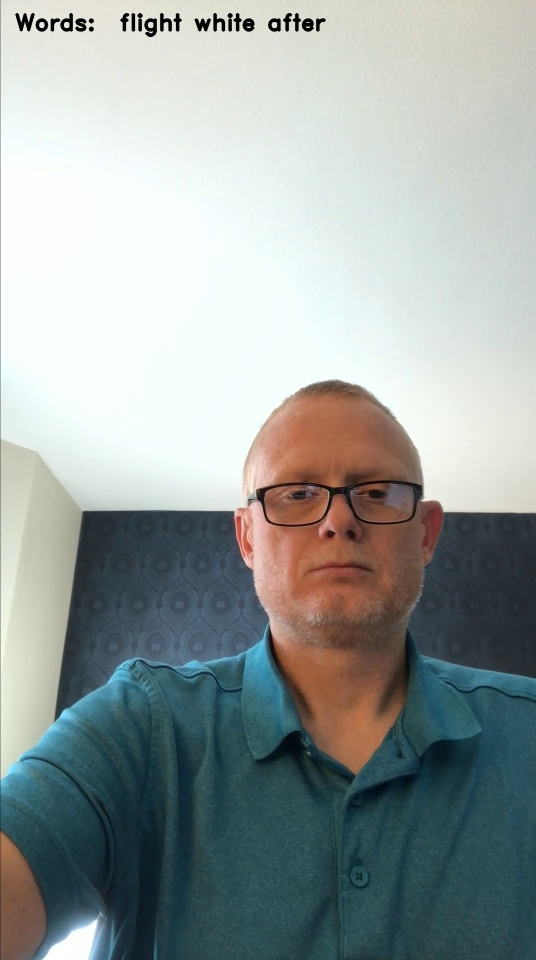


Done


In [11]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'output-frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

print("\nDone")

<h1>Create a video from the annotated frames</h1>

This command requires ffmpeg. It will combine the annotated frames to build an MP4 video which you can play at full speed (the notebook playback above was most likely slow).

Uncomment the command to try running it from this notebook, or copy the output files to a system with ffmpeg and run the command there.

NOTE: The command below requires libx264 for encoding video stream into the H.264/MPEG-4 AVC compression format. Please check that ffmpeg was configured and built with --enable-libx264 (ffmpeg 2>&1 | grep libx264). If not, just remove the -vcodec libx264 option from the following command.

In [12]:
import ffmpeg
#ffmpeg -y -r 60 -f image2 -i output/output-frame_%05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuvj420p annotated_video.mp4
!ffmpeg -r 20 -f image2 -i output/output-frame_%05d.jpg -crf 25  -pix_fmt yuvj420p annotated_video.mp4

'ffmpeg' is not recognized as an internal or external command,
operable program or batch file.
